# Creating the Bathymetry

In this notebook, we will explore how to create the grid of a model. This will be demonstrated for Mike's example model in the California current. You are encouraged to follow along with this notebook to generate the model grid in the domain for your project.

First, import packages to re-create and visualize the model grid here:

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import netCDF4 as nc4

### Bathymetry Source File
To generate the bathymetry for the model, first obtain a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/

For Mike's model, I requested a subset covering my grid ranging from 136-114 $^{\circ}$ W in longitude and 28-54 $^{\circ}$ N in latitude, and I stored the bathymetry as `GEBCO_Bathymetry_California.nc`.

### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [2]:
import xarray as xr
# read in the bathymetry grid
file_path = 'global_bathymetry.nc'
ds = nc4.Dataset(file_path)

Globe_bathy_lon = ds.variables['longitude'][:]
Globe_bathy_lat = ds.variables['latitude'][:]
Globe_bathy = ds.variables['Depth'][:]
Globe_bathy = Globe_bathy*-1
ds.close()

# create a meshgrid of the lon and lat
Globe_Lon, Globe_Lat = np.meshgrid(Globe_bathy_lon, Globe_bathy_lat)

In [3]:
delX = 1/2  
delY = 1/2  
xgOrigin = -180 
ygOrigin = -90  

n_cols = 720 
n_rows = 360

xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)
print('Double check shape:', np.shape(xc),np.shape(yc))

Double check shape: (720,) (360,)


In [4]:
# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Globe_Lon.ravel(),Globe_Lat.ravel()]), Globe_bathy.ravel(), (XC, YC), method='nearest')

In [5]:
# set points on land to 0
Model_bathy[Model_bathy>0] = 0

### Visualizing the Bathymetry Grid
Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

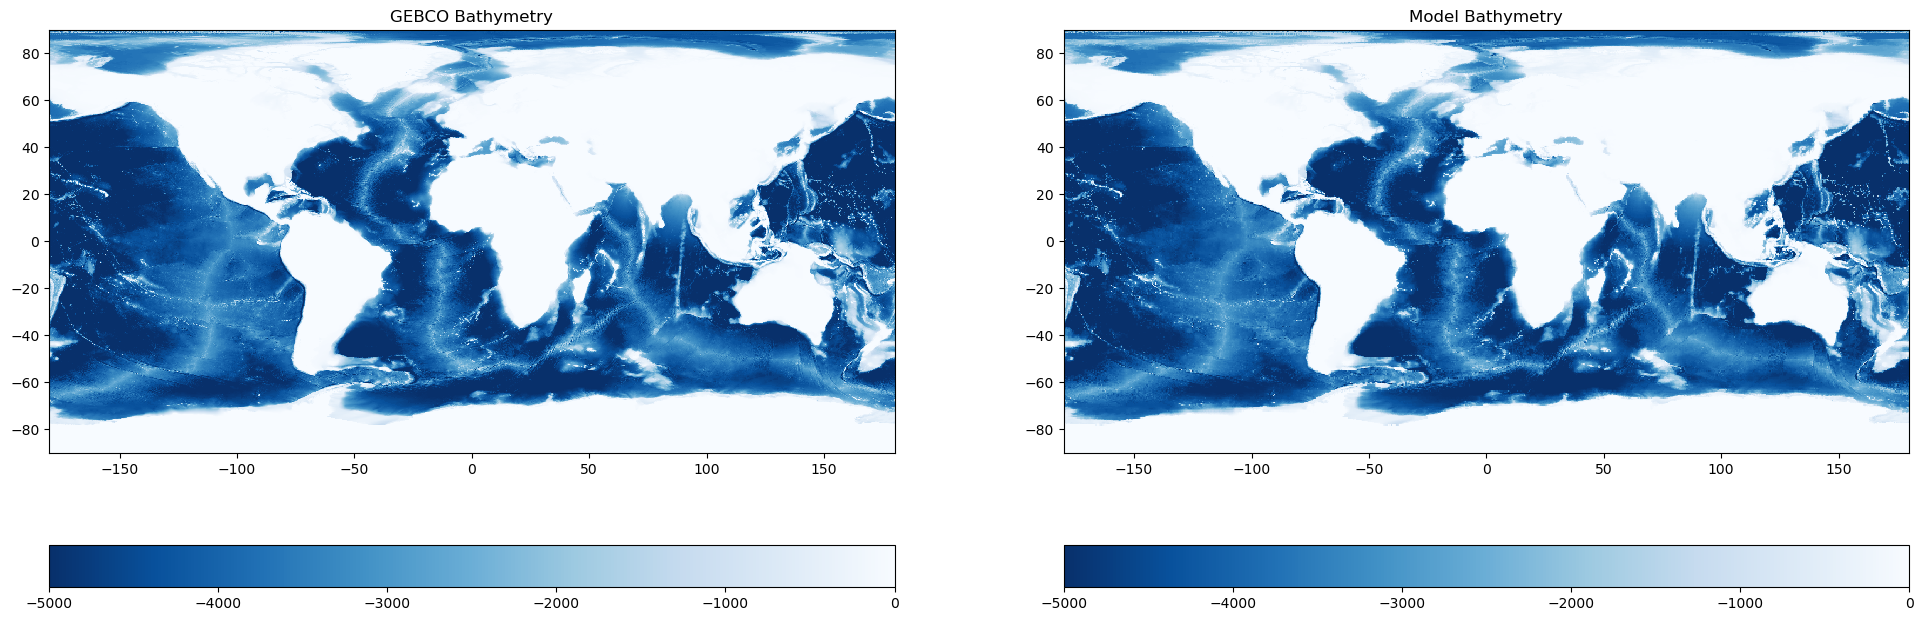

In [6]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
C = plt.pcolormesh(Globe_Lon, Globe_Lat, Globe_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC , Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()
plt.close()

### Checking for isolated regions
One potential problem that can be encountered in ocean models occurs with isolated regions

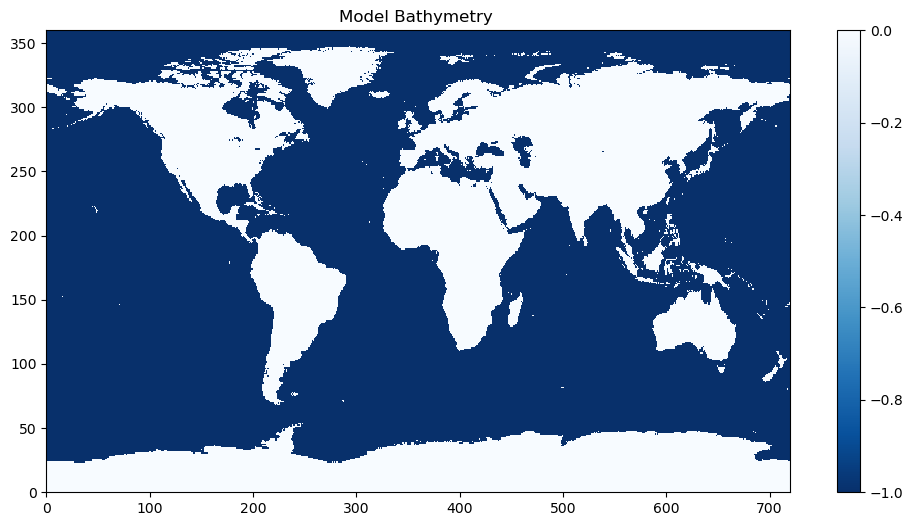

In [ ]:
plt.figure(figsize=(12,6))

C = plt.pcolormesh(Model_bathy, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry ')

plt.show()

As we can see, there are several isolated water regions, such as the Great Lakes. In addition, there is extreme detail in some areas. Before proceeding with the model, these regions need to be addressed.

Fortunately, Mike has written a tool to fill in these unconnected regions (Thanks Mike!). You can clone his [eccoseas](https://github.com/mhwood/eccoseas) repository to access a tool related to this process. If you clone it in the current directory, you can use import it here:

In [8]:
import os
import sys
from scipy.ndimage import binary_opening, binary_closing
sys.path.append(os.path.abspath(os.path.join('../../../downscale_ecco')))
from eccoseas.downscale import bathymetry as edb

Make a binary grid that we will use to mask the model grid

In [9]:
binary_grid = np.copy(Model_bathy)
binary_grid[binary_grid<0] = -1
binary_grid[binary_grid>=0] = 0

With the tools imported, we can now use the `fill_unconnected_model_regions` to fill in these regions.

In [10]:
model_binary_grid = edb.fill_unconnected_model_regions(binary_grid, central_wet_row=100, central_wet_col=100)

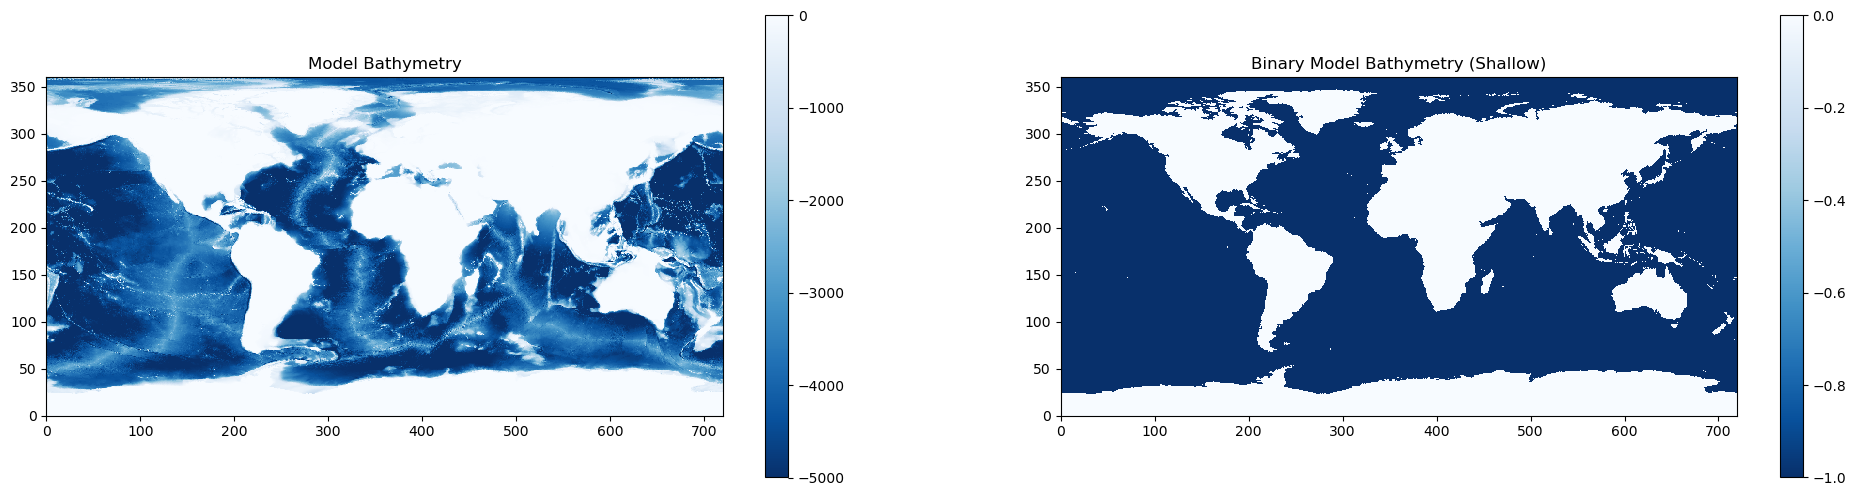

In [11]:
plt.figure(figsize=(24,6))

plt.subplot(1,2,1)
C = plt.pcolormesh(Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Model Bathymetry')
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,2,2)
C = plt.pcolormesh(binary_grid, vmin=-1, vmax=0, cmap='Blues_r')
plt.colorbar(C)
plt.title('Binary Model Bathymetry (Shallow)')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

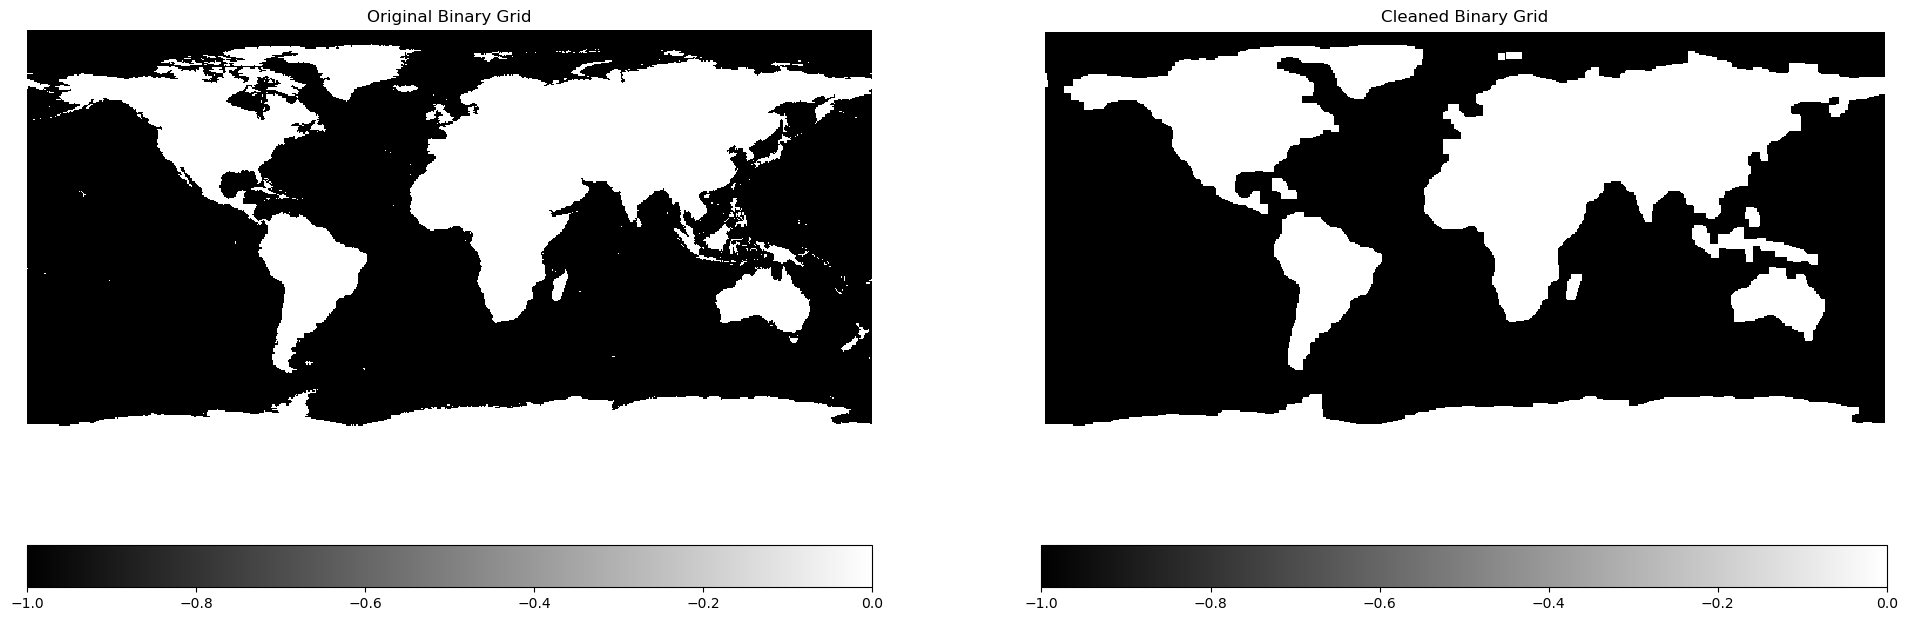

In [12]:
model_binary_grid_bin = np.copy(model_binary_grid)
model_binary_grid_bin = model_binary_grid_bin * -1


structure = np.ones((6,6))

# close holes of 1s
opened_grid = binary_opening(model_binary_grid_bin, structure=structure)
# close holes of 0s
cleaned_grid = binary_closing(opened_grid, structure=structure)
cleaned_grid = cleaned_grid*-1

# flood with Mike's code
cleaned_grid = edb.fill_unconnected_model_regions(cleaned_grid, central_wet_row=100, central_wet_col=100)



fig, axs = plt.subplots(1, 2, figsize=(24, 8))

C = axs[0].pcolormesh(model_binary_grid_bin*-1, cmap='gray')
axs[0].set_title('Original Binary Grid')
axs[0].axis('off')
axs[0].set_aspect('equal', adjustable='box')
cbar = plt.colorbar(C, ax=axs[0], orientation='horizontal')
plt.gca().set_aspect('equal', adjustable='box')

C = axs[1].pcolormesh(cleaned_grid, cmap='gray')
axs[1].set_title('Cleaned Binary Grid')
axs[1].axis('off')
axs[1].set_aspect('equal', adjustable='box')
cbar = plt.colorbar(C, ax=axs[1], orientation='horizontal')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()
plt.close()

Pretty good, but the borders could be smoother. Lets take advantage of the entropy of morpological operations. That is, we will dialate and erode the grid repeatedlly in order to smooth the borders. 

https://en.wikipedia.org/wiki/Mathematical_morphology

In [13]:
from scipy.ndimage import binary_dilation, binary_erosion

def smooth_binary_grid(grid, iterations):
    # erode then dialate to smooth the borders
    smoothed_grid = grid.copy()
    for _ in range(iterations):
        smoothed_grid = binary_erosion(smoothed_grid)
        smoothed_grid = binary_dilation(smoothed_grid)
    return smoothed_grid

smoothed_grid = smooth_binary_grid(cleaned_grid*-1, iterations=15000)
smoothed_grid = smoothed_grid*-1

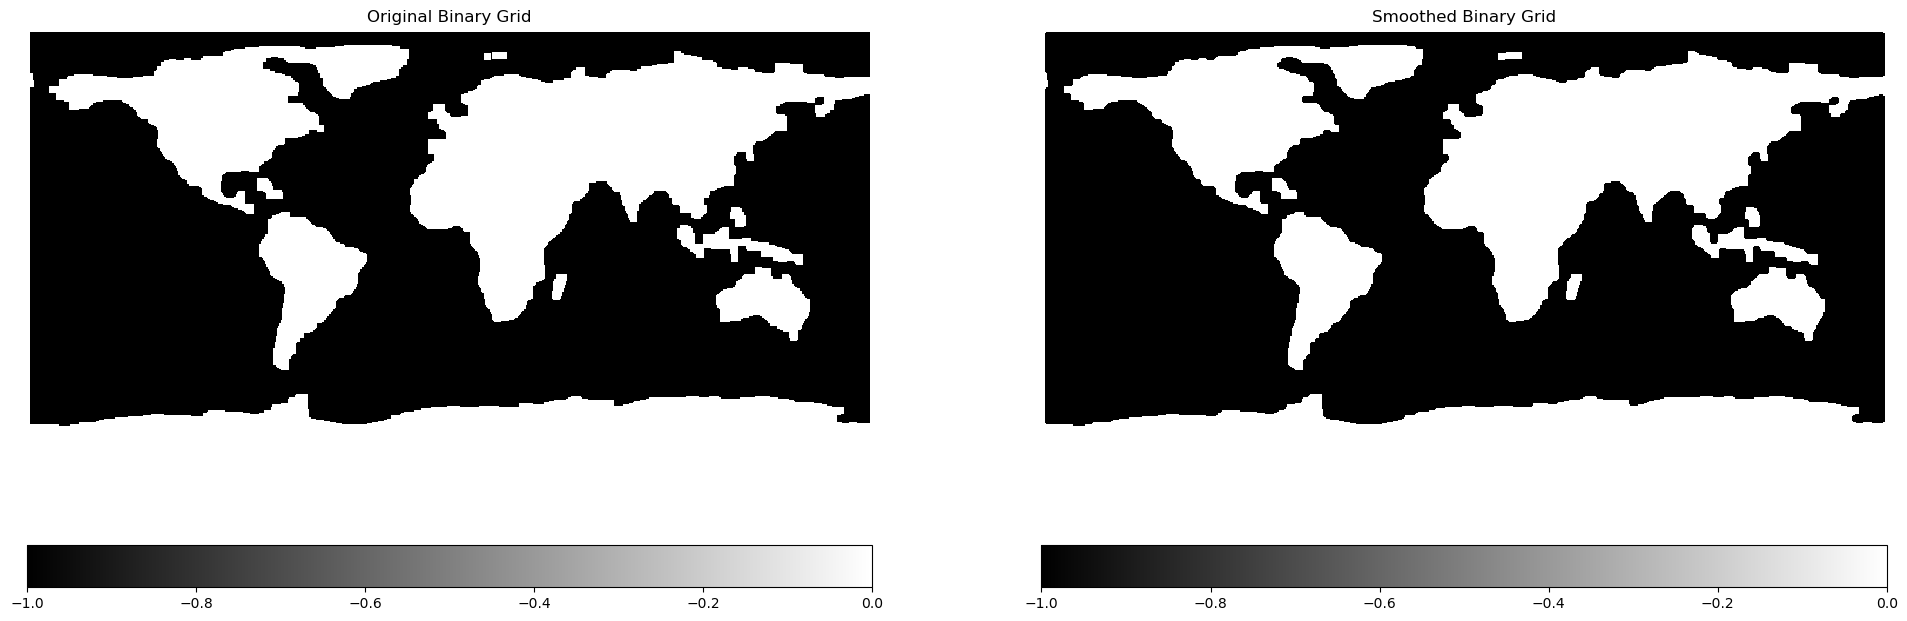

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

C = axs[0].pcolormesh(cleaned_grid, cmap='gray')
axs[0].set_title('Original Binary Grid')
axs[0].axis('off')
axs[0].set_aspect('equal', adjustable='box')
cbar = plt.colorbar(C, ax=axs[0], orientation='horizontal')
plt.gca().set_aspect('equal', adjustable='box')

C = axs[1].pcolormesh(smoothed_grid, cmap='gray')
axs[1].set_title('Smoothed Binary Grid')
axs[1].axis('off')
axs[1].set_aspect('equal', adjustable='box')
cbar = plt.colorbar(C, ax=axs[1], orientation='horizontal')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

Note the islands east of Greenland are now connected. 

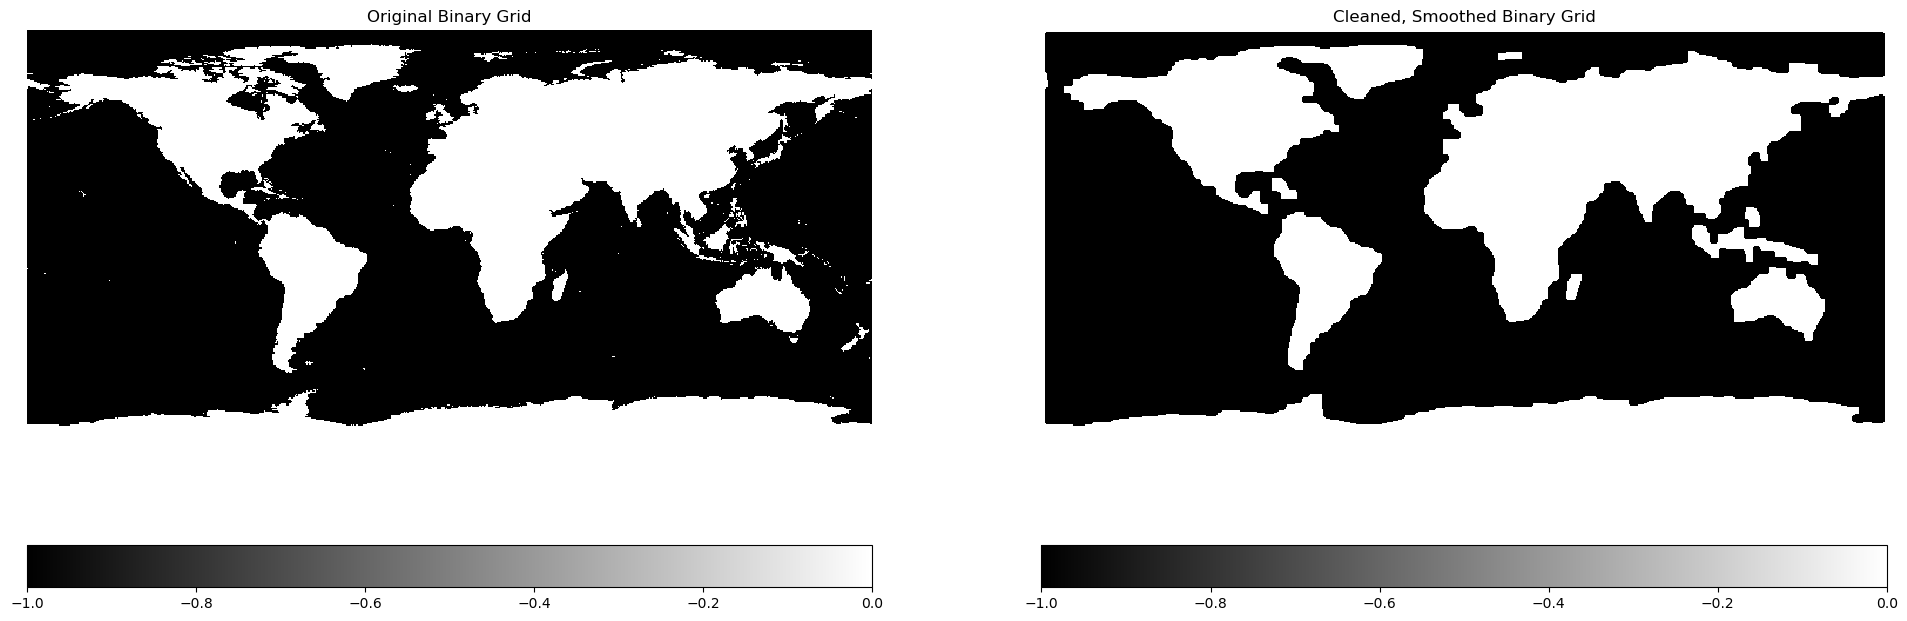

In [15]:
# Plot the original and cleaned grids
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# axs[0].imshow(model_binary_grid_bin, cmap='gray')
C = axs[0].pcolormesh(model_binary_grid_bin*-1, cmap='gray')
axs[0].set_title('Original Binary Grid')
axs[0].axis('off')
axs[0].set_aspect('equal', adjustable='box')
cbar = plt.colorbar(C, ax=axs[0], orientation='horizontal')
plt.gca().set_aspect('equal', adjustable='box')


# axs[1].imshow(cleaned_grid, cmap='gray')
C = axs[1].pcolormesh(smoothed_grid, cmap='gray')
axs[1].set_title('Cleaned, Smoothed Binary Grid')
axs[1].axis('off')
axs[1].set_aspect('equal', adjustable='box')
cbar = plt.colorbar(C, ax=axs[1], orientation='horizontal')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [41]:
# Sink the ocean 1 meter.. then set values in Model_bathy to 0 where cleaned_grid is 0
# flood once more to be safe
Model_bathy_cleaned = (np.copy(Model_bathy)-1) * (smoothed_grid*-1)
Model_bathy_cleaned = edb.fill_unconnected_model_regions(Model_bathy_cleaned, central_wet_row=100, central_wet_col=100)

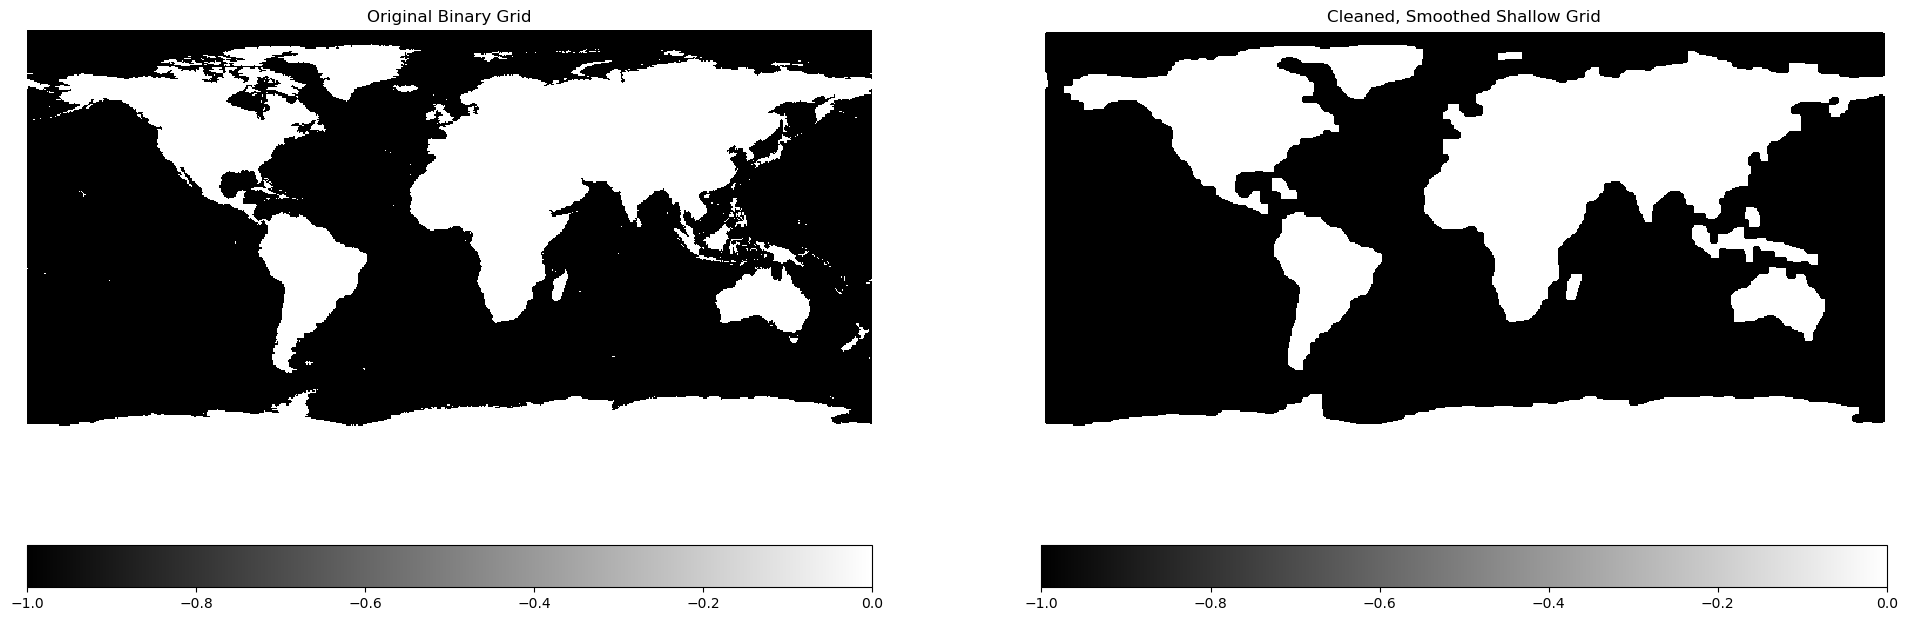

In [42]:
# Plot the original and cleaned grids
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

# axs[0].imshow(model_binary_grid_bin, cmap='gray')
C = axs[0].pcolormesh(model_binary_grid_bin*-1, cmap='gray')
axs[0].set_title('Original Binary Grid')
axs[0].axis('off')
axs[0].set_aspect('equal', adjustable='box')
cbar = plt.colorbar(C, ax=axs[0], orientation='horizontal')
plt.gca().set_aspect('equal', adjustable='box')


# axs[1].imshow(cleaned_grid, cmap='gray')
C = axs[1].pcolormesh(Model_bathy_cleaned, cmap='gray', vmin = -1, vmax = 0)
axs[1].set_title('Cleaned, Smoothed Shallow Grid')
axs[1].axis('off')
axs[1].set_aspect('equal', adjustable='box')
cbar = plt.colorbar(C, ax=axs[1], orientation='horizontal')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

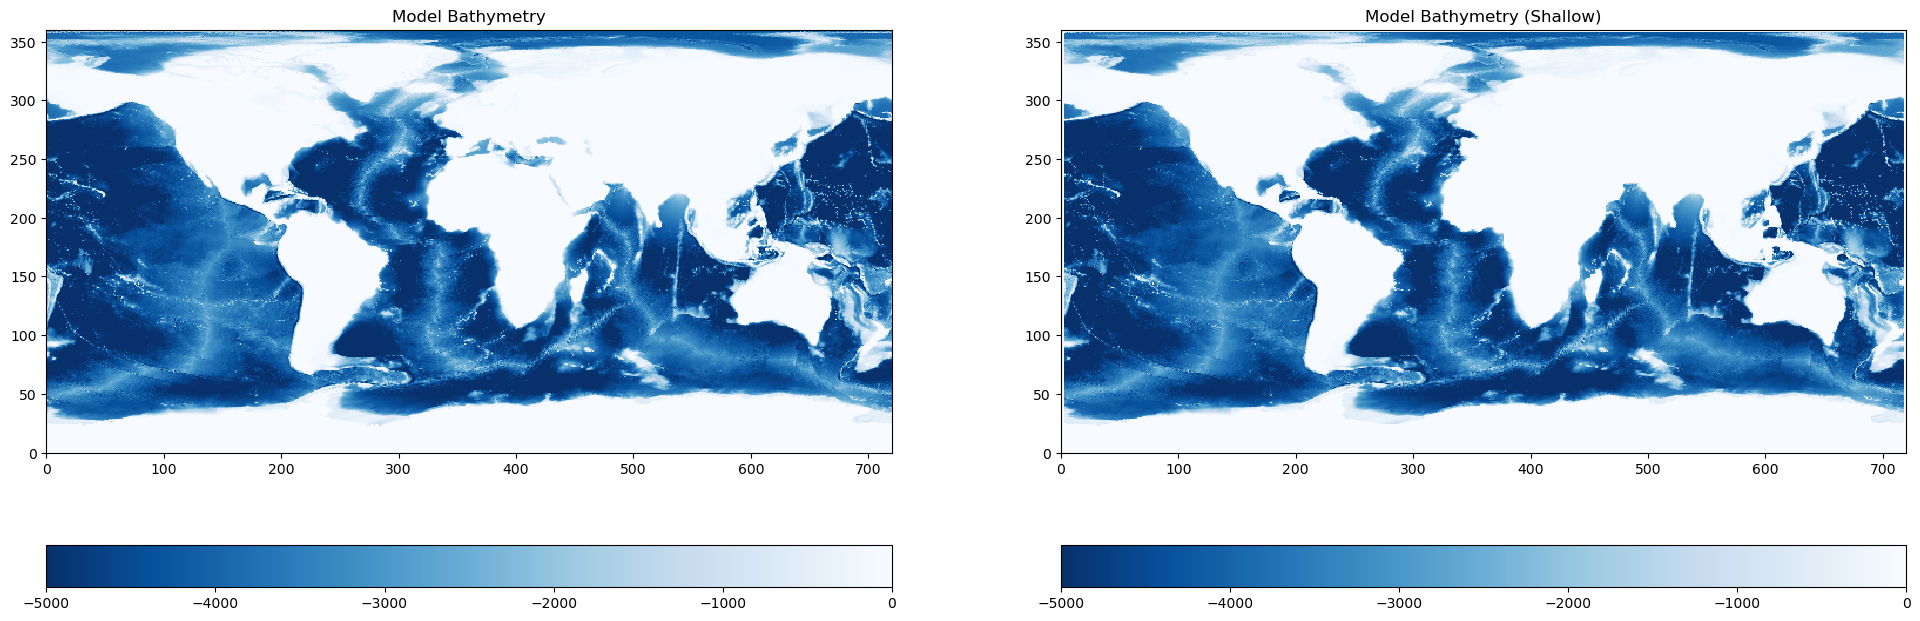

In [43]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
C = plt.pcolormesh(Model_bathy, vmin=-5000, vmax=0, cmap='Blues_r')
# plt.colorbar(C)
plt.title('Model Bathymetry')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(C, orientation='horizontal')

plt.subplot(1,2,2)
C = plt.pcolormesh(Model_bathy_cleaned, vmin=-5000, cmap='Blues_r')
# plt.colorbar(C)
plt.title('Model Bathymetry (Shallow)')
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(C, orientation='horizontal')

plt.show()

In [44]:
output_file = 'global_bathymetry.bin'
Model_bathy_cleaned.ravel('C').astype('>f4').tofile(output_file)

This will be implemented into the model by editing the `PARM05` dataset of the `data` file as follows:
```
 &PARM05
 bathyFile = 'global_bathymetry.bin,
 &
```